In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
import numpy as np
import requests
from datetime import datetime, timedelta, date
from IPython.display import display, HTML
from liualgotrader.analytics import analysis

%matplotlib inline
import json
import math
from dateutil import parser
from pytz import timezone
import sys
import pytz
import asyncio
import nest_asyncio
nest_asyncio.apply()

In [2]:
day_to_analyze = datetime.strptime("2020-10-27", "%Y-%m-%d")
env = "PAPER"

In [3]:
trades = analysis.load_trades(day_to_analyze, env)
algo_runs = analysis.load_runs(day_to_analyze, env)

[4765]2020-10-27 21:47:20.678419:db connection pool initialized


In [4]:
symbol_name = []
counts = []
revenues = []
est = pytz.timezone("US/Eastern")
batch_ids = trades.batch_id.unique().tolist()
#batch_ids.reverse()

current_max = pd.options.display.max_rows
pd.set_option("display.max_rows", None)
for batch_id in batch_ids:
    how_was_my_day = pd.DataFrame()
    how_was_my_day["symbol"] = trades.loc[trades["batch_id"] == batch_id][
        "symbol"
    ].unique()
    how_was_my_day["revenues"] = how_was_my_day["symbol"].apply(
        lambda x: analysis.calc_batch_revenue(x, trades, batch_id)
    )
    how_was_my_day["count"] = how_was_my_day["symbol"].apply(
        lambda x: analysis.count_trades(x, trades, batch_id)
    )

    if len(algo_runs.loc[algo_runs["batch_id"] == batch_id]
        .start_time) > 0:
        batch_time = (
            algo_runs.loc[algo_runs["batch_id"] == batch_id]
            .start_time.min()
            .tz_localize("utc")
            .astimezone(est)
        ) 
    else:
        continue
    
    env = algo_runs[algo_runs["batch_id"] == batch_id].algo_env.tolist()[0]
    print(
        f"[{env}] {batch_id}\n{batch_time}\nTotal revenues=${round(sum(how_was_my_day['revenues']),2)}"
    )
    display(how_was_my_day)

pd.set_option("display.max_rows", current_max)

[PAPER] 2f906a57-bd24-4002-813d-a3ec474ad570
2020-10-27 09:30:06.109763-04:00
Total revenues=$-79.46


,symbol,revenues,count
0,APHA,-17.67,2
1,ARI,9.12,3
2,BE,-4.41,2
3,FLDM,-19.96,2
4,GNMK,-28.22,4
5,LMNL,5.64,2
6,PRTS,-10.20,2
7,TFFP,-15.50,2
8,VLDR,1.74,2


[PAPER] 74598bd6-7c39-4beb-9b4d-3225cded8e1f
2020-10-27 10:46:51.669359-04:00
Total revenues=$-65.65


,symbol,revenues,count
0,ARI,-24.06,2
1,CLNY,-7.66,2
2,DBD,-33.93,2


[PAPER] fecc2eb0-3d1a-4408-8ea3-069f1c633fc4
2020-10-27 11:41:04.065311-04:00
Total revenues=$-28.20


,symbol,revenues,count
0,ASO,7.80,2
1,BLNK,-12.35,2
2,CHFS,5.96,2
3,CLNY,5.79,4
4,PECK,-17.88,2
5,PLUG,1.35,2
6,TFFP,-12.42,2
7,WIFI,-6.45,2


In [5]:
api = tradeapi.REST(base_url="https://api.alpaca.markets")
minute_history = {}
for symbol in trades.symbol.unique().tolist():
    minute_history[symbol] = api.polygon.historic_agg_v2(
        symbol,
        1,
        "minute",
        _from=str((day_to_analyze - timedelta(days=10)).date()),
        to=str((day_to_analyze + timedelta(days=1)).date()),
    ).df

APHA analysis with profit $-17.67


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-2785.97,-2785.97,buy,2020-10-27 10:16:19.142967-04:00,4.73,589,2.49%,1.07%,"{'buy': {'avg': 4.6643, 'macd': [0.010715660029531726, 0.01082457798075609, 0.011584276341621624, 0.013690771908207111, 0.015536137130936822], 'vwap': 4.7389, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.012013798711259573, 0.011775954565158876, 0.011737618920451425, 0.012128249518002562, 0.012809827040589413]}, 'sell': None}",5.24,4.57
1,-17.67,2768.30,sell,2020-10-27 10:19:46.500280-04:00,4.70,589,1.84%,,"{'buy': None, 'sell': {'avg': 4.6675, 'rsi': [63.59316244880255, 63.593162448802545, 53.90594630875148], 'vwap': 4.7018, 'reasons': 'MACD cross signal from above', 'movement': -0.0061310782241016494, 'sell_macd': [0.007764907025167744, 0.007937113911355098, 0.008227961953690688, 0.008347740143125115, 0.007387207042124366], 'sell_macd_signal': [0.006670869564765415, 0.006924118434083352, 0.0071848871380048186, 0.007417457739028878, 0.0074114075996479754]}}",5.24,4.57


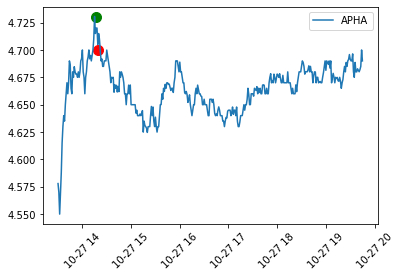

ARI analysis with profit $-14.94


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-2143.20,-2143.20,buy,2020-10-27 10:07:16.689804-04:00,9.40,228,2.51%,0.18%,"{'buy': {'avg': 9.1867, 'macd': [0.06087417298562947, 0.06428819849888079, 0.07181442135400395, 0.07769035753560871, 0.08140865103930928], 'vwap': 9.4, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.0769735093837099, 0.07443644720674408, 0.07391204203619606, 0.0746677051360786, 0.07601589431672473]}, 'sell': None}",10.71,8.96
1,-1199.20,944.00,sell,2020-10-27 10:16:21.630596-04:00,9.44,100,2.94%,,"{'buy': None, 'sell': {'avg': 9.239, 'rsi': [72.10630156805531, 68.53141250495591, 68.94592030174938], 'vwap': 9.46, 'reasons': 'MACD cross signal from above', 'movement': 0.006382978723404308, 'sell_macd': [0.049978906535722345, 0.0508465038184589, 0.05112194970346806, 0.04963370039693693, 0.048089172360718635], 'sell_macd_signal': [0.046972199976419014, 0.04774706074482699, 0.048422038536555204, 0.04866437090863155, 0.048549331199048966]}}",10.71,8.96
2,9.12,1208.32,sell,2020-10-27 10:16:21.776482-04:00,9.44,128,2.94%,,"{'buy': None, 'sell': {'avg': 9.239, 'rsi': [72.10630156805531, 68.53141250495591, 68.94592030174938], 'vwap': 9.46, 'reasons': 'MACD cross signal from above', 'movement': 0.006382978723404308, 'sell_macd': [0.049978906535722345, 0.0508465038184589, 0.05112194970346806, 0.04963370039693693, 0.048089172360718635], 'sell_macd_signal': [0.046972199976419014, 0.04774706074482699, 0.048422038536555204, 0.04866437090863155, 0.048549331199048966]}}",10.71,8.96
3,-3776.32,-3785.44,buy,2020-10-27 10:50:23.701012-04:00,9.44,401,2.94%,1.45%,"{'buy': {'avg': 9.3027, 'macd': [0.004238828016715601, 0.0042638556816463336, 0.00662803569625936, 0.007607059517436454, 0.009085131633545629], 'vwap': 9.4358, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.008617349184029633, 0.007746650483552974, 0.007522927526094251, 0.007539753924362692, 0.007848829466199279]}, 'sell': None}",10.19,9.19
4,-14.94,3761.38,sell,2020-10-27 10:51:42.476711-04:00,9.38,401,2.29%,,"{'buy': None, 'sell': {'avg': 9.303, 'rsi': [55.13315912145633, 50.84661755440118, 50.846617554401185], 'vwap': 9.41, 'reasons': 'MACD cross signal from above', 'movement': -0.003177966101694848, 'sell_macd': [0.0005892486277669917, 0.0022700576248659843, 0.0030308171339701317, 0.0025452944510142572, 0.002133909315579885], 'sell_macd_signal': [0.0021573524886303575, 0.0021798935158774827, 0.0023500782394960127, 0.0023891214817996615, 0.002338079048555706]}}",10.19,9.19


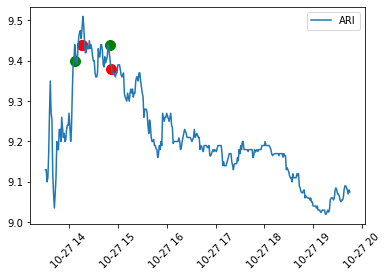

ASO analysis with profit $7.80


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1977.30,-1977.30,buy,2020-10-27 12:44:22.265213-04:00,15.21,130,1.13%,1.74%,"{'buy': {'avg': 15.3011, 'macd': [-0.001249689420104616, -0.006909220737634669, -0.007593151365091089, -0.012702796641484326, -0.012363522874498045], 'vwap': 15.25, 'reason': ['MACD signal'], 'macd_signal': [0.00045583475950411223, -0.0010171763399236442, -0.002332371344957133, -0.004406456404262572, -0.0059978696983096665]}, 'sell': None}",18.33,14.49
1,7.80,1985.10,sell,2020-10-27 13:07:26.336792-04:00,15.27,130,1.53%,,"{'buy': None, 'sell': {'avg': 15.299, 'rsi': [54.70629722810344, 50.61116469039517, 54.29561885021076], 'vwap': 15.32, 'reasons': 'MACD cross signal from above', 'movement': 0.007232084155161041, 'sell_macd': [0.016217800770245816, 0.016794665167132905, 0.01598709631838169, 0.013591755704830177, 0.013107181776026877], 'sell_macd_signal': [0.011349262890043295, 0.012438343345461216, 0.01314809394004531, 0.013236826293002284, 0.013210897389607203]}}",18.33,14.49


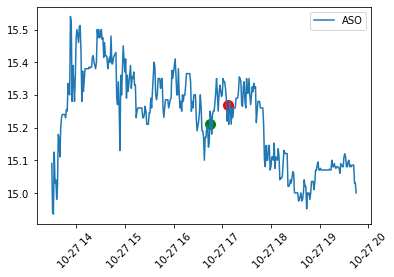

BE analysis with profit $-4.41


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-2443.14,-2443.14,buy,2020-10-27 10:07:29.165859-04:00,16.62,147,3.42%,0.91%,"{'buy': {'avg': 16.2163, 'macd': [0.09398207146506721, 0.0903786267960136, 0.10007873565306724, 0.11118077267038373, 0.11768657634297952], 'vwap': 16.6266, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.11102087638838014, 0.10689242646990683, 0.10552968830653892, 0.10665990517930787, 0.10886523941204221]}, 'sell': None}",18.66,15.95
1,-4.41,2438.73,sell,2020-10-27 10:14:52.825308-04:00,16.59,147,3.24%,,"{'buy': None, 'sell': {'avg': 16.2818, 'rsi': [68.5197170750252, 63.87271487527308, 58.2951372272816], 'vwap': 16.6018, 'reasons': 'MACD cross signal from above', 'movement': -0.001119133574007177, 'sell_macd': [0.06854235109926776, 0.0678973597209449, 0.07268960852068318, 0.07236292435786851, 0.0671062493692105], 'sell_macd_signal': [0.06374339335924102, 0.06457418663158179, 0.06619727100940206, 0.06743040167909535, 0.06736557121711838]}}",18.66,15.95


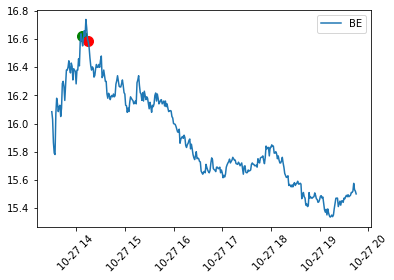

BLNK analysis with profit $-12.35


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1993.29,-1993.29,buy,2020-10-27 13:51:06.265786-04:00,8.07,247,-0.26%,0.71%,"{'buy': {'avg': 8.1483, 'macd': [-0.016298948729451368, -0.01691286684818749, -0.018210558020603784, -0.018985245193647415, -0.01778389435194505], 'vwap': 8.07, 'reason': ['MACD signal'], 'macd_signal': [-0.009574336032254036, -0.011042042195440726, -0.012475745360473339, -0.013777645327108155, -0.014578895132075534]}, 'sell': None}",9.75,7.67
1,-12.35,1980.94,sell,2020-10-27 13:55:08.235038-04:00,8.02,247,-0.87%,,"{'buy': None, 'sell': {'avg': 8.1474, 'rsi': [44.17531011672576, 44.17531011672576, 41.866553996502816], 'vwap': 8.0201, 'reasons': 'MACD cross signal from above', 'movement': -0.006195786864931934, 'sell_macd': [-0.0027460511466852466, -0.002978262637851614, -0.003640008440866538, -0.004108381684241991, -0.004934277955907618], 'sell_macd_signal': [-0.0049011566198150875, -0.004516577823422393, -0.004341263946911222, -0.004294687494377376, -0.0044226055866834245]}}",9.75,7.67


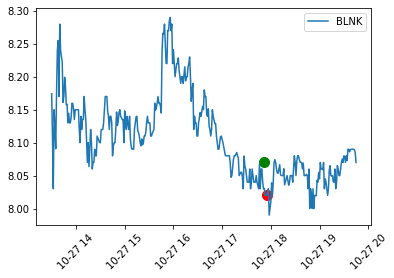

CHFS analysis with profit $5.96


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1993.62,-1993.62,buy,2020-10-27 13:29:10.986019-04:00,6.69,298,-0.3%,9.11%,"{'buy': {'avg': 7.321, 'macd': [-0.05262830982099853, -0.06326280369379234, -0.06709146380643993, -0.06920351761101706, -0.06787260476249202], 'vwap': 6.6766, 'reason': ['MACD signal'], 'macd_signal': [-0.026979847037861666, -0.0342364383690478, -0.040807443456526225, -0.04648665828742439, -0.05076384758243792]}, 'sell': None}",8.11,6.36
1,5.96,1999.58,sell,2020-10-27 13:48:11.701315-04:00,6.71,298,0.0%,,"{'buy': None, 'sell': {'avg': 7.3176, 'rsi': [54.38743739701033, 49.62116227867497, 42.87686147991724], 'vwap': 6.7004, 'reasons': 'bail', 'movement': 0.0014947683109117766, 'sell_macd': [0.019061923042547946, 0.018321740838691092, 0.016977160668949942, 0.014150511696827017, 0.009187531826382767], 'sell_macd_signal': [0.009794468669406826, 0.01149992310326368, 0.012595370616400932, 0.012906398832486149, 0.012162625431265473]}}",8.11,6.36


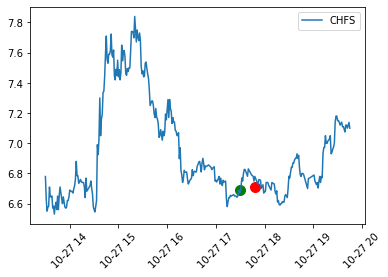

CLNY analysis with profit $-1.87


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-2696.32,-2696.32,buy,2020-10-27 10:30:12.706999-04:00,3.52,766,3.23%,2.04%,"{'buy': {'avg': 3.4797, 'macd': [-0.004575211204595142, -0.003348468148372863, -0.0019503250912369374, -3.49671394497264e-05, 0.0018649283172433861], 'vwap': 3.5179, 'reason': ['MACD histogram reversal'], 'macd_signal': [-0.00040249090793930374, -0.0009916863560260156, -0.0011834141030682, -0.0009537247103445053, -0.00038999410482692693]}, 'sell': None}",3.91,3.39
1,-7.66,2688.66,sell,2020-10-27 10:57:47.682287-04:00,3.51,766,2.93%,,"{'buy': {'reason': 'stopped', 'close_5m': [3.51, 3.515, 3.515, 3.51, 3.51]}, 'sell': None}",2.34,2.63
2,-2001.70,-1994.04,buy,2020-10-27 12:58:29.683324-04:00,3.48,573,2.05%,2.75%,"{'buy': {'avg': 3.5039, 'macd': [-0.003513449994180906, -0.004413655221258583, -0.005317533901822102, -0.005693055810029879, -0.0056519942344772645], 'vwap': 3.4767, 'reason': ['MACD signal'], 'macd_signal': [0.0015078919997472918, 0.0003235825555461167, -0.0008046407359275272, -0.0017823237507479976, -0.0025562578474938513]}, 'sell': None}",4.20,3.31
3,-19.12,1982.58,sell,2020-10-27 13:07:10.700773-04:00,3.46,573,1.47%,,"{'buy': None, 'sell': {'avg': 3.5028, 'rsi': [48.25294975221989, 34.26681304419258, 34.26681304419258], 'vwap': 3.465, 'reasons': 'MACD cross signal from above', 'movement': -0.004310344827586242, 'sell_macd': [-0.0008073829894130746, -0.0006832426097642674, -0.0005776365657559346, -0.0010073248877522367, -0.00132906481544115], 'sell_macd_signal': [-0.0014030199144982654, -0.0012590644535514658, -0.0011227788759923594, -0.0010996880783443348, -0.0011455634257636978]}}",4.20,3.31
4,-2014.37,-1995.25,buy,2020-10-27 13:15:09.895672-04:00,3.47,575,1.76%,2.71%,"{'buy': {'avg': 3.5024, 'macd': [-0.0059117344942172245, -0.006005357696256652, -0.006260059442050103, -0.006636969121343039, -0.006584730311423925], 'vwap': 3.467, 'reason': ['MACD signal'], 'macd_signal': [-0.0026082058994418428, -0.003287636258804805, -0.0038821208954538645, -0.0044330905406317, -0.004863418494790145]}, 'sell': None}",4.20,3.30
5,-1.87,2012.50,sell,2020-10-27 13:36:09.641538-04:00,3.50,575,2.64%,,"{'buy': None, 'sell': {'avg': 3.5014, 'rsi': [63.83349729646992, 63.83349729646992, 63.83349729646992], 'vwap': 3.5, 'reasons': 'MACD cross signal from above', 'movement': 0.008645533141210318, 'sell_macd': [0.004776528233192412, 0.004631176857293529, 0.004457770890914148, 0.004264756230216715, 0.004058968751358805], 'sell_macd_signal': [0.0039386684721544815, 0.004077170149182291, 0.004153290297528663, 0.004175583484066273, 0.0041522605375247795]}}",4.20,3.30


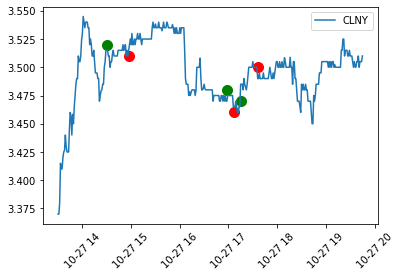

DBD analysis with profit $-33.93


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1996.65,-1996.65,buy,2020-10-27 10:04:05.203926-04:00,7.65,261,1.73%,-0.27%,"{'buy': {'avg': 7.4995, 'macd': [0.056227000658212845, 0.05426852820620809, 0.05434928593519306, 0.05554817833328496, 0.055854453820868954], 'vwap': 7.65, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.05518421209966277, 0.05500107532097183, 0.054870717443816074, 0.05500620962170985, 0.055175858461541674]}, 'sell': None}",8.80,7.27
1,-33.93,1962.72,sell,2020-10-27 11:22:15.974996-04:00,7.52,261,0.0%,,"{'buy': None, 'sell': {'avg': 7.5418, 'rsi': [46.999384457890045, 43.560637710355685, 40.3790167075922], 'vwap': 7.52, 'reasons': 'MACD cross signal from above', 'movement': -0.016993464052287684, 'sell_macd': [-0.0018150493009727597, -0.001579539271481245, -0.0016352517254958343, -0.0021769075114095315, -0.0030901859483369876], 'sell_macd_signal': [-0.0034857544292048698, -0.0031045113976601447, -0.0028106594632272826, -0.0026839090728637324, -0.0027651644479583836]}}",8.80,7.27


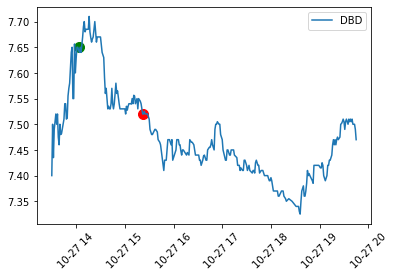

FLDM analysis with profit $-19.96


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-3253.48,-3253.48,buy,2020-10-27 10:37:56.996561-04:00,6.52,499,2.35%,1.06%,"{'buy': {'avg': 6.4378, 'macd': [0.000783524639191846, 0.0002768137704336482, 0.0014721050980970318, 0.0031895315787657808, 0.006891908091213317], 'vwap': 6.508, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.0030771376097171502, 0.00251707284186045, 0.002308079293107766, 0.002484369750239369, 0.0033658774184341586]}, 'sell': None}",7.12,6.32
1,-19.96,3233.52,sell,2020-10-27 10:44:49.740358-04:00,6.48,499,1.73%,,"{'buy': None, 'sell': {'avg': 6.4416, 'rsi': [53.03203531173424, 53.03203531173423, 49.916930483815825], 'vwap': 6.48, 'reasons': 'MACD cross signal from above', 'movement': -0.006134969325153244, 'sell_macd': [0.00599921164806716, 0.005562053256130461, 0.005149175895450497, 0.004760580862512853, 0.0038764732931779733], 'sell_macd_signal': [0.0035052593326237134, 0.003916618117325063, 0.00416312967295015, 0.0042826199108626905, 0.004201390587325747]}}",7.12,6.32


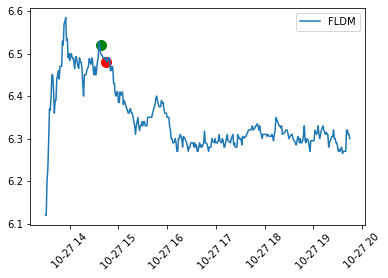

GNMK analysis with profit $-28.22


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-2648.70,-2648.70,buy,2020-10-27 10:30:10.288337-04:00,12.15,218,5.84%,3.05%,"{'buy': {'avg': 11.8301, 'macd': [0.026225085145826554, 0.027855142928077115, 0.029612536997611016, 0.03304511027718959, 0.039346469852048926], 'vwap': 12.15, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.035195523223880296, 0.03372744716471966, 0.03290446513129793, 0.03293259416047627, 0.0342153692987908]}, 'sell': None}",13.52,11.69
1,-19.62,2629.08,sell,2020-10-27 10:34:15.213650-04:00,12.06,218,5.05%,,"{'buy': None, 'sell': {'avg': 11.8466, 'rsi': [63.96168787563119, 57.280328868822295, 56.37436023469574], 'vwap': 12.08, 'reasons': 'MACD cross signal from above', 'movement': -0.005761316872428006, 'sell_macd': [0.02266641399256919, 0.02405125816980558, 0.024298523007004746, 0.022357449854084166, 0.020294828567987366], 'sell_macd_signal': [0.018182661309766597, 0.019356380681774393, 0.020344809146820464, 0.020747337288273205, 0.02065683554421604]}}",13.52,11.69
2,-2631.87,-2612.25,buy,2020-10-27 10:38:57.293803-04:00,12.15,215,5.84%,3.28%,"{'buy': {'avg': 11.8561, 'macd': [0.03727753789653576, 0.03507619568984843, 0.03614265184483756, 0.038959474737266575, 0.04032354424287732], 'vwap': 12.155, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.03858551929738587, 0.03788365457587838, 0.03753545402967022, 0.03782025817118949, 0.03832091538552705]}, 'sell': None}",13.54,11.69
3,-28.22,2603.65,sell,2020-10-27 10:40:23.238772-04:00,12.11,215,5.49%,,"{'buy': None, 'sell': {'avg': 11.8696, 'rsi': [66.96558952216907, 60.652317816273346, 59.64307368268105], 'vwap': 12.13, 'reasons': 'MACD cross signal from above', 'movement': -0.0016460905349793887, 'sell_macd': [0.01972242374769273, 0.021631681539174608, 0.023098224213844887, 0.022382566243280166, 0.02127448774357532], 'sell_macd_signal': [0.020195819900956234, 0.02048299222859991, 0.021006038625648905, 0.02128134414917516, 0.02127997286805519]}}",13.54,11.69


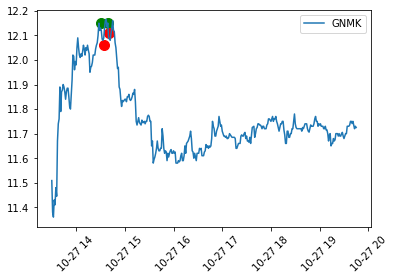

LMNL analysis with profit $5.64


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1748.40,-1748.40,buy,2020-10-27 10:05:36.715030-04:00,6.20,282,2.99%,-1.34%,"{'buy': {'avg': 5.9392, 'macd': [0.03884135494238894, 0.03475961930791005, 0.036701739602174044, 0.040995973569450506, 0.0510726984888894], 'vwap': 6.1911, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.041575646656571236, 0.040212441186839, 0.03951030086990601, 0.039807435409814906, 0.042060488025629804]}, 'sell': None}",7.26,5.85
1,5.64,1754.04,sell,2020-10-27 10:17:13.739704-04:00,6.22,282,3.32%,,"{'buy': None, 'sell': {'avg': 5.9961, 'rsi': [63.83990464869537, 63.83990464869535, 60.33357638946411], 'vwap': 6.2236, 'reasons': 'MACD cross signal from above', 'movement': 0.003806451612903236, 'sell_macd': [0.043374487946940654, 0.04110015628963026, 0.04139158413731536, 0.04108111773113077, 0.03893424627525732], 'sell_macd_signal': [0.037649603741438734, 0.03833971425107704, 0.0389500882283247, 0.039376294128885915, 0.039287884558160194]}}",7.26,5.85


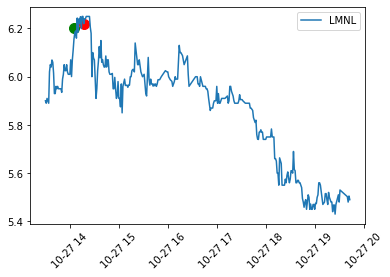

PECK analysis with profit $-17.88


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1996.60,-1996.60,buy,2020-10-27 12:57:52.729214-04:00,6.70,298,3.59%,5.63%,"{'buy': {'avg': 6.832, 'macd': [-0.008586835739767373, -0.013317867443033649, -0.01636389386839543, -0.016966461292464707, -0.01669617017755165], 'vwap': 6.7, 'reason': ['MACD signal'], 'macd_signal': [0.0061093763940571625, 0.0022239276266390003, -0.0014936366723678862, -0.00458820159638725, -0.00700979531262013]}, 'sell': None}",8.05,6.37
1,-17.88,1978.72,sell,2020-10-27 14:23:26.821127-04:00,6.64,298,2.66%,,"{'buy': None, 'sell': {'avg': 6.8285, 'rsi': [53.73375604456901, 45.255340644987854, 45.255340644987854], 'vwap': 6.65, 'reasons': 'MACD cross signal from above', 'movement': -0.007462686567164152, 'sell_macd': [9.429091021218028e-05, -0.00014879180649085555, 0.0014819072688894153, -0.0006432870524877288, -0.0022909282502823203], 'sell_macd_signal': [-0.004373630597287485, -0.003528662839128159, -0.0025265488175246443, -0.002149896464517261, -0.002178102821670273]}}",8.05,6.37


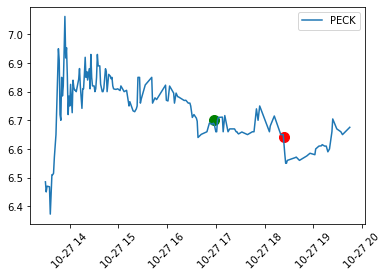

PLUG analysis with profit $1.35


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1987.20,-1987.20,buy,2020-10-27 12:56:54.235961-04:00,14.72,135,1.38%,2.31%,"{'buy': {'avg': 14.8548, 'macd': [-0.02197612544186356, -0.029014725579179057, -0.03593552145787804, -0.038523991993773876, -0.03848222887896746], 'vwap': 14.7198, 'reason': ['MACD signal'], 'macd_signal': [0.013598622506371722, 0.005075952889261565, -0.0031263419801663556, -0.01020587198288786, -0.01586114336210378]}, 'sell': None}",17.74,13.98
1,1.35,1988.55,sell,2020-10-27 13:20:22.187498-04:00,14.73,135,1.45%,,"{'buy': None, 'sell': {'avg': 14.8507, 'rsi': [54.85462014053818, 49.99952691744654, 49.99952691744654], 'vwap': 14.7398, 'reasons': 'MACD cross signal from above', 'movement': 0.0013519021739130303, 'sell_macd': [0.011962508841698138, 0.011858033295220949, 0.011103142826598855, 0.009326563983170999, 0.007815897819680728], 'sell_macd_signal': [0.006769193759670777, 0.007786961666780811, 0.00845019789874442, 0.008625471115629736, 0.008463556456439935]}}",17.74,13.98


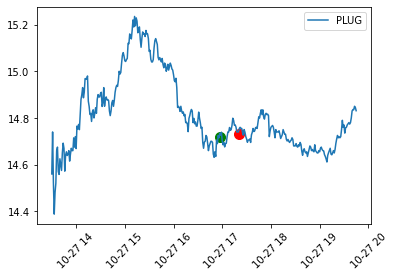

PRTS analysis with profit $-10.20


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-3452.70,-3452.70,buy,2020-10-27 10:34:15.405106-04:00,13.54,255,2.58%,2.03%,"{'buy': {'avg': 13.4681, 'macd': [-0.0038156842892913545, -0.004259307665348544, -0.004558336718778477, -0.0015497886926194582, 0.003218159632064399], 'vwap': 13.54, 'reason': ['MACD zero-cross'], 'macd_signal': [0.0026411270325985433, 0.0012610400930091257, 9.716473065160504e-05, -0.00023222595400260762, 0.0004578511632107938]}, 'sell': None}",14.71,13.15
1,-10.20,3442.50,sell,2020-10-27 10:46:15.772796-04:00,13.50,255,2.27%,,"{'buy': None, 'sell': {'avg': 13.4789, 'rsi': [56.26057687798727, 49.64308044196649, 49.6273253046733], 'vwap': 13.52, 'reasons': 'MACD cross signal from above', 'movement': -0.0014771048744460543, 'sell_macd': [0.01121475202345934, 0.012619117633452248, 0.01251058281483175, 0.010190807854673523, 0.008245648043452292], 'sell_macd_signal': [0.007956588908744597, 0.008889094653686128, 0.009613392285915252, 0.009728875399666905, 0.009432229928423982]}}",14.71,13.15


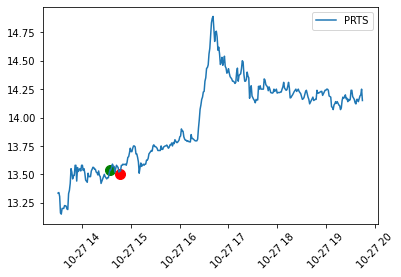

TFFP analysis with profit $-27.92


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-2354.45,-2354.45,buy,2020-10-27 10:17:26.535202-04:00,15.19,155,5.05%,2.65%,"{'buy': {'avg': 14.8431, 'macd': [0.09955008986351999, 0.09911166711526143, 0.10242502060747682, 0.1125329184078474, 0.1184677908336873], 'vwap': 15.146, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.10678155134049172, 0.10524757449544567, 0.1046830637178519, 0.106253034655851, 0.10869598589141825]}, 'sell': None}",17.12,14.55
1,-15.50,2338.95,sell,2020-10-27 10:19:15.781971-04:00,15.09,155,4.36%,,"{'buy': None, 'sell': {'avg': 14.8559, 'rsi': [65.36170478543653, 65.59050576147858, 60.83057481506427], 'vwap': 15.09, 'reasons': 'MACD cross signal from above', 'movement': -0.006583278472679371, 'sell_macd': [0.05912460732173663, 0.06564387338789857, 0.06681675768116868, 0.06712268365409102, 0.06363220150761428], 'sell_macd_signal': [0.061120651312898844, 0.06202529572789879, 0.06298358811855277, 0.06381140722566042, 0.06377556608205119]}}",17.12,14.55
2,-2001.32,-1985.82,buy,2020-10-27 12:59:04.907827-04:00,14.39,138,-0.48%,2.46%,"{'buy': {'avg': 14.8152, 'macd': [-0.07815792953904932, -0.08302115822125344, -0.08521300968503276, -0.08633376394661418, -0.08569105604724037], 'vwap': 14.4076, 'reason': ['MACD signal'], 'macd_signal': [-0.027572802818395196, -0.03866247389896685, -0.04797258105618003, -0.05564481763426686, -0.06165406531686156]}, 'sell': None}",17.54,13.69
3,-27.92,1973.40,sell,2020-10-27 13:02:41.712509-04:00,14.30,138,-1.11%,,"{'buy': None, 'sell': {'avg': 14.8084, 'rsi': [31.74226949423349, 32.59707772408329, 32.32677180193982], 'vwap': 14.3019, 'reasons': 'MACD cross signal from above', 'movement': -0.0061223071577484875, 'sell_macd': [-0.02618435485220516, -0.02971328875278978, -0.03207722050970219, -0.033242917716261644, -0.033880565958824604], 'sell_macd_signal': [-0.03572892876055046, -0.034525800758998325, -0.034036084709139096, -0.033877451310563605, -0.03387807424021581]}}",17.54,13.69


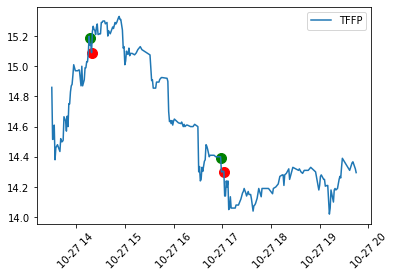

VLDR analysis with profit $1.74


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-2538.66,-2538.66,buy,2020-10-27 10:03:20.119743-04:00,14.59,174,2.42%,0.49%,"{'buy': {'avg': 14.3156, 'macd': [0.06322223285021522, 0.06431021750755583, 0.0668229095609405, 0.07281635308355305, 0.07826971934105842], 'vwap': 14.5963, 'reason': ['MACD histogram reversal'], 'macd_signal': [0.06892998351776577, 0.06800603031572379, 0.06776940616476713, 0.06877879554852431, 0.07067698030703114]}, 'sell': None}",16.32,14.03
1,1.74,2540.40,sell,2020-10-27 10:10:19.310291-04:00,14.60,174,2.49%,,"{'buy': None, 'sell': {'avg': 14.3855, 'rsi': [65.83778544535184, 64.0822014348547, 61.43586928762983], 'vwap': 14.6, 'reasons': 'MACD cross signal from above', 'movement': 0.0006854009595613288, 'sell_macd': [0.05029760860859689, 0.054465351662161154, 0.05388871830568931, 0.0520122674005723, 0.04878370478099292], 'sell_macd_signal': [0.0450333791948892, 0.04691977368834359, 0.04831356261181273, 0.049053303569564645, 0.0489993838118503]}}",16.32,14.03


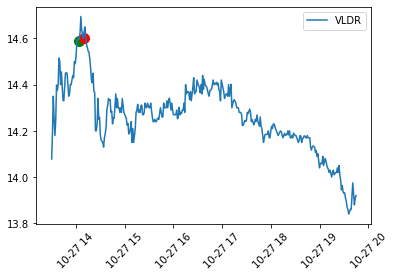

WIFI analysis with profit $-6.45


,profit,trade,operation,at,price,qty,daily change,vwap,indicators,target price,stop price
0,-1995.20,-1995.20,buy,2020-10-27 13:23:41.294819-04:00,9.28,215,-2.93%,-1.86%,"{'buy': {'avg': 9.382, 'macd': [-0.020278407566888035, -0.020885012291431693, -0.022125418410666953, -0.02280462553720497, -0.022518233356102257], 'vwap': 9.2777, 'reason': ['MACD signal'], 'macd_signal': [-0.0077806345675107014, -0.0104015101122949, -0.012746291771969311, -0.014757958525016443, -0.016310013491233608]}, 'sell': None}",11.15,8.82
1,-6.45,1988.75,sell,2020-10-27 13:31:37.747636-04:00,9.25,215,-3.24%,,"{'buy': None, 'sell': {'avg': 9.3812, 'rsi': [44.83074490682148, 43.15530042928802, 35.92570392447556], 'vwap': 9.2491, 'reasons': 'MACD cross signal from above', 'movement': -0.0032327586206895866, 'sell_macd': [-0.005794209722987276, -0.006014916953766658, -0.005589300290038679, -0.005444802885964606, -0.006606950325830141], 'sell_macd_signal': [-0.006117993293282202, -0.0060973780253790934, -0.0059957624783110106, -0.00588557055984173, -0.006029846513039412]}}",11.15,8.82


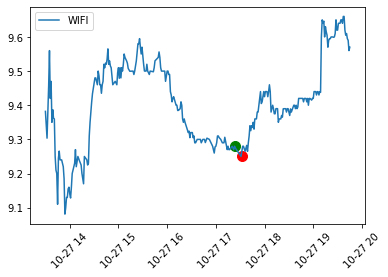

In [6]:
est = pytz.timezone("US/Eastern")
position = {}
for symbol in minute_history:
    symbol_df = trades.loc[trades["symbol"] == symbol]
    start_date = symbol_df["tstamp"].min().to_pydatetime()
    start_date = start_date.replace(
        hour=9, minute=30, second=0, microsecond=0, tzinfo=None
    )
    end_date = start_date.replace(hour=16, minute=0, tzinfo=None)
    cool_down_date = start_date + timedelta(minutes=5)
    try:
        start_index = minute_history[symbol]["close"].index.get_loc(
            start_date, method="nearest"
        )
        end_index = minute_history[symbol]["close"].index.get_loc(
            end_date, method="nearest"
        )
    except Exception as e:
        print(f"Error for {symbol}: {e}")
        continue

    cool_minute_history_index = minute_history[symbol]["close"].index.get_loc(
        cool_down_date, method="nearest"
    )
    open_price = float(minute_history[symbol]["close"][cool_minute_history_index])
    plt.plot(
        minute_history[symbol]["close"][start_index:end_index],
        label=symbol,
    )
    plt.xticks(rotation=45)

    delta = 0
    profit = 0

    operations = []
    deltas = []
    profits = []
    times = []
    prices = []
    qtys = []
    indicators = []
    target_price = []
    stop_price = []
    daily_change = []
    precent_vwap = []
    for index, row in symbol_df.iterrows():

        try:
            now = int(row["client_time"])
            continue
        except Exception:
            pass

        delta = (
            row["price"]
            * row["qty"]
            * (1 if row["operation"] == "sell" and row["qty"] > 0 else -1)
        )

        profit += delta
        plt.scatter(
            row["tstamp"].to_pydatetime(),
            row["price"],
            c="g" if row["operation"] == "buy" else "r",
            s=100,
        )
        deltas.append(round(delta, 2))
        profits.append(round(profit, 2))
        operations.append(row["operation"])
        times.append(pytz.utc.localize(pd.to_datetime(row["tstamp"])).astimezone(est))
        prices.append(row["price"])
        qtys.append(row["qty"])
        indicator = json.loads(row.indicators)
        indicators.append(indicator)
        target_price.append(row["target_price"])
        stop_price.append(row["stop_price"])
        daily_change.append(
            f"{round(100.0 * (float(row['price']) - open_price) / open_price, 2)}%"
        )
        precent_vwap.append(
            f"{round(100.0 * (indicator['buy']['avg'] - open_price) / open_price, 2)}%"
            if indicator['buy'] and "avg" in indicator['buy']
            else ""
        )

    d = {
        "profit": profits,
        "trade": deltas,
        "operation": operations,
        "at": times,
        "price": prices,
        "qty": qtys,
        "daily change": daily_change,
        "vwap": precent_vwap,
        "indicators": indicators,
        "target price": target_price,
        "stop price": stop_price,
    }
    print(f"{symbol} analysis with profit ${round(profit, 2)}")
    display(HTML(pd.DataFrame(data=d).to_html()))
    plt.legend()
    plt.show()